<a href="https://colab.research.google.com/github/BossAyush07/Deep-Learning-Projects/blob/master/Eng_to_Spanish_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Important Libraries

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import io
import time
from google.colab import files
from string import digits
from nltk.translate.bleu_score import sentence_bleu

In [6]:
data_path = "spa.txt"

## Understanding the data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Read the data
lines_raw= pd.read_table(data_path,names=['source', 'target', 'comments'])
lines_raw.sample(5)

,source,target,comments
698,I was sad.,Estuve triste.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
11950,I need the money.,Necesito la plata.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
63824,The main valve is turned off.,La válvula principal está cerrada.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
37415,Tom may have been sick.,Puede que Tom haya estado enfermo.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
67603,"Our summer is short, but warm.","Nuestro verano es corto, pero cálido.",CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [71]:
len(lines_raw)

71931

###Clean and Preprocess the text

Convert to lower case

Convert special characters

Remove Digits

Remove spaces

Add start and end tags to each sentence

In [9]:
def preprocess_sentence(sentence):
    #sentence = unicode_to_ascii(sentence.lower().strip())
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= sentence.strip()
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

In [10]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

start_ may i borrow this book ? _end
b'start_ \xc2\xbf puedo tomar prestado este libro ? _end'


In [11]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #print(lines)
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  print(path)
  return zip(*word_pairs)

In [12]:
sample_size=60000
source, target = create_dataset(data_path, sample_size)
print(source[-1])
print(target[-1])
type(target)

spa.txt
start_ tom made himself a sandwich . _end
start_ tom se hizo un sándwich . _end


tuple

In [13]:
def max_length(tensor):
  return max(len(t) for t in tensor)

###Create the source and target toekns and post pad them







In [14]:
source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )

In [15]:
target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )
print(len(target_tensor[0]))

20


###Creating Train and Test dataset

In [16]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)

In [17]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

48000 48000 12000 12000


In [18]:
type(input_tensor_train)

numpy.ndarray

In [19]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [20]:
print ("Input Language; index to word mapping")
convert(source_sentence_tokenizer, source_train_tensor[0])
print ()
print ("Target Language; index to word mapping")
convert( target_sentence_tokenizer, target_train_tensor[0])

Input Language; index to word mapping
1 ----> start_
41 ----> they
283 ----> felt
13 ----> he
19 ----> was
84 ----> too
1139 ----> weak
3 ----> .
2 ----> _end

Target Language; index to word mapping
1 ----> start_
60 ----> ellos
4395 ----> sintieron
12 ----> que
16 ----> él
79 ----> era
113 ----> demasiado
1364 ----> débil
3 ----> .
2 ----> _end


###Create a tf.data dataset

In [21]:
BUFFER_SIZE = len(source_train_tensor)
BATCH_SIZE = 64
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_sentence_tokenizer.word_index)+1
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [22]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 13]), TensorShape([64, 20]))

###Write the encoder and decoder model

In [23]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [24]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 13, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [25]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [26]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 13, 1)


In [27]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [28]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 15349)


##Define the optimizer and the loss function

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

###Checkpoints (Object-based saving)

In [30]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [95]:
act = "puede que tom hayaestado enfermo."
pred = translatee(u'tom may have been sick.')

###Training

Pass the input through the encoder which return encoder output and the encoder hidden state.

The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.

The decoder returns the predictions and the decoder hidden state.

The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.

Use teacher forcing to decide the next input to the decoder.

Teacher forcing is the technique where the target word is passed as the next input to the decoder.

The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [31]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [32]:
steps_per_epoch

750

In [33]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 2.929354190826416
Epoch 1 Batch 100 loss 1.5624536275863647
Epoch 1 Batch 200 loss 1.5000457763671875
Epoch 1 Batch 300 loss 1.3340100049972534
Epoch 1 Batch 400 loss 1.1841086149215698
Epoch 1 Batch 500 loss 1.3030389547348022
Epoch 1 Batch 600 loss 1.1054136753082275
Epoch 1 Batch 700 loss 1.0727628469467163
Epoch 1 Loss 1.3316
Time taken for 1 epoch 126.24873304367065 sec

Epoch 2 Batch 0 loss 0.97889244556427
Epoch 2 Batch 100 loss 0.9670166969299316
Epoch 2 Batch 200 loss 0.9076053500175476
Epoch 2 Batch 300 loss 0.9308255314826965
Epoch 2 Batch 400 loss 0.8875002264976501
Epoch 2 Batch 500 loss 0.7491058707237244
Epoch 2 Batch 600 loss 0.7226148843765259
Epoch 2 Batch 700 loss 0.6775697469711304
Epoch 2 Loss 0.8286
Time taken for 1 epoch 106.21266174316406 sec

Epoch 3 Batch 0 loss 0.6952165961265564
Epoch 3 Batch 100 loss 0.6274794936180115
Epoch 3 Batch 200 loss 0.5603978037834167
Epoch 3 Batch 300 loss 0.5267680883407593
Epoch 3 Batch 400 loss 0.5110331773

##Translate

The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.

Stop predicting when the model predicts the end token or when the max traget legth is reached

And store the attention weights for every time step.

Note: The encoder output is calculated only once for one input

In [35]:
#Calculating the max length of the source and target sentences
max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in source_tensor)

In [36]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocess_sentence(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

##To Plot Attention weights

In [37]:
#function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [85]:
def translatee(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  #print('Input: %s' % (sentence))
  #print('Predicted translation: {}'.format(result))
  return result

 # attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
 # plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [86]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

##Restore the latest checkpoint and test

In [87]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

##Final translations with Attention Plots

Input: start_ i am going to work . _end
Predicted translation: voy a trabajar . _end 


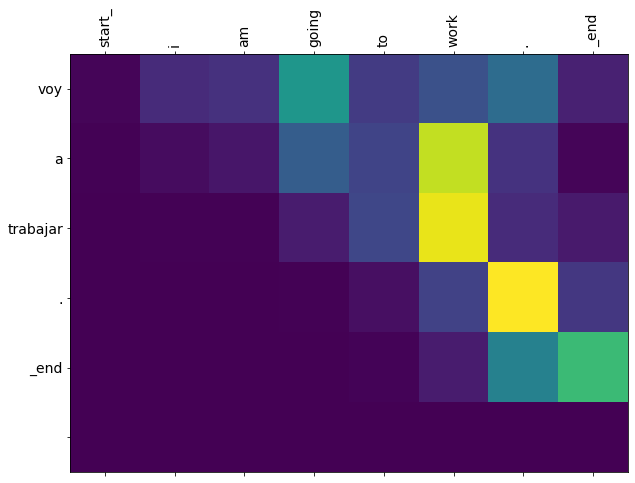

In [88]:
translate(u'I am going to work.')

Input: start_ you need to work smart . _end
Predicted translation: necesitas trabajar . _end 


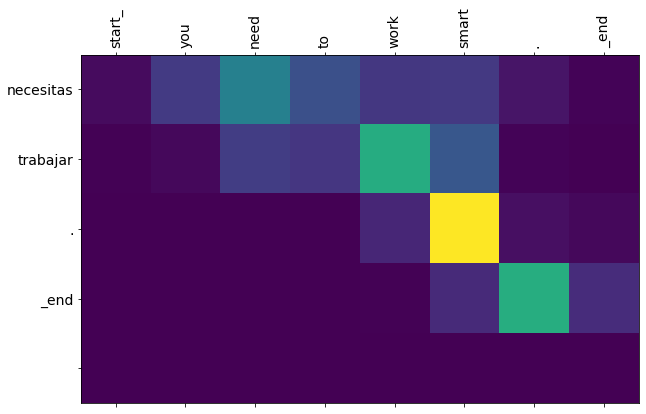

In [89]:
translate(u'You need to work smart.')

In [96]:
translatee(u'tom may have been sick.')

'tom pudo haber sido enfermo . _end '

###Calculating the bleu score

In [97]:
print('Cumulative 1-gram: %f' % sentence_bleu(act, pred, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(act, pred, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(act, pred, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(act, pred, weights=(0.25, 0.25, 0.25, 0.25)))

Cumulative 1-gram: 0.428571
Cumulative 2-gram: 0.654654
Cumulative 3-gram: 0.756080
Cumulative 4-gram: 0.809107


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
